In [0]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

0it [00:00, ?it/s]

 99%|█████████▉| 169582592/170498071 [00:11<00:00, 33181102.05it/s]

Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


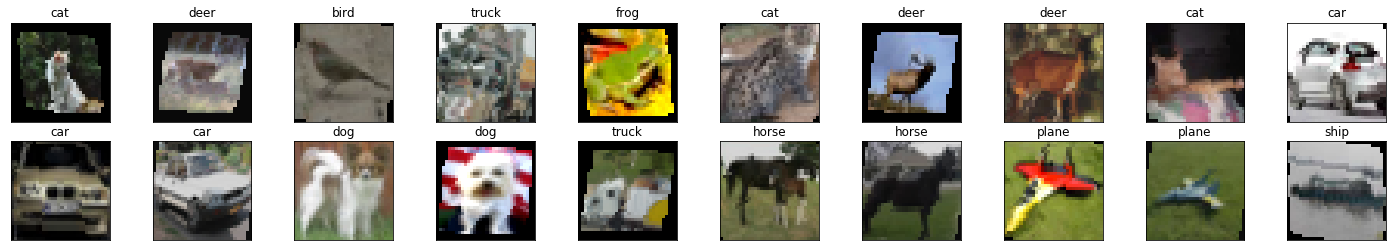

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

170500096it [00:30, 33181102.05it/s]                               

epoch : 1
training loss: 1.6927, acc 38.0660 
validation loss: 1.4043, validation acc 48.8400 
epoch : 2
training loss: 1.3959, acc 49.4920 
validation loss: 1.2343, validation acc 56.1500 
epoch : 3
training loss: 1.2604, acc 55.1660 
validation loss: 1.1206, validation acc 60.0600 
epoch : 4
training loss: 1.1757, acc 58.2480 
validation loss: 1.0753, validation acc 61.5300 
epoch : 5
training loss: 1.1084, acc 60.5560 
validation loss: 1.0251, validation acc 63.7800 
epoch : 6
training loss: 1.0554, acc 62.7400 
validation loss: 1.0129, validation acc 64.5500 
epoch : 7
training loss: 1.0160, acc 64.2240 
validation loss: 0.9170, validation acc 68.0200 
epoch : 8
training loss: 0.9900, acc 65.2240 
validation loss: 0.9361, validation acc 67.1900 
epoch : 9
training loss: 0.9504, acc 66.5760 
validation loss: 0.8708, validation acc 69.8800 
epoch : 10
training loss: 0.9308, acc 67.2080 
validation loss: 0.8476, validation acc 70.5500 
epoch : 11
training loss: 0.9126, acc 68.0320 
va

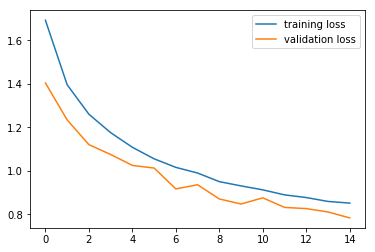

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

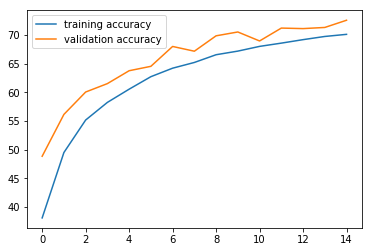

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
import PIL.ImageOps


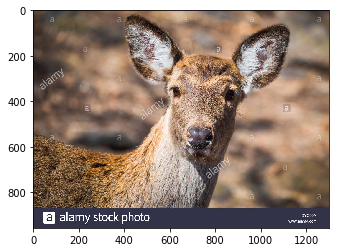

In [37]:
import requests
from PIL import Image



url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

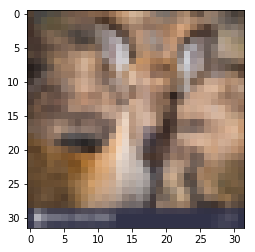

In [38]:
img = transform(img) 
plt.imshow(im_convert(img))

In [39]:
image = img.to(device).unsqueeze(0)
model.eval()
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


acertos: 74 
erros:26


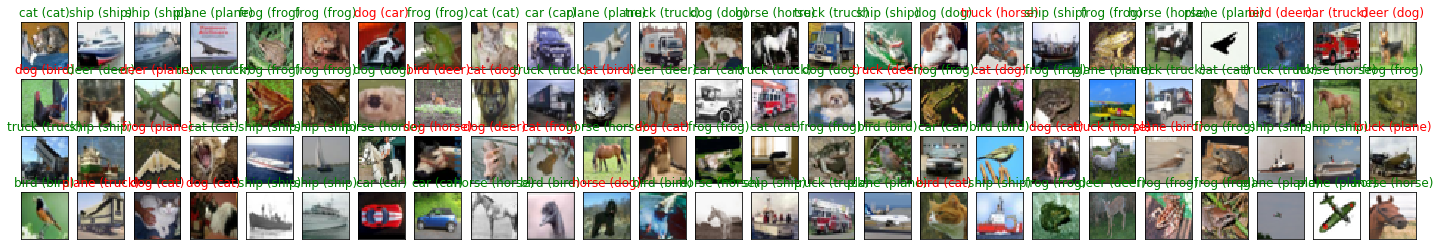

In [25]:

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))


acertos = 0
erros = 0

for idx in np.arange(100):
  ax = fig.add_subplot(4,25,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))
  if preds[idx]==labels[idx]:
    acertos = acertos +1
  else:
    erros = erros +1
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

print('acertos: {} \nerros:{}'.format(acertos,erros))

https://i.imgur.com/L93iqLv.jpg
https://i.imgur.com/L93iqLv.jpg <Response [200]>
https://i.imgur.com/5I6c1Xf.jpg
https://i.imgur.com/5I6c1Xf.jpg <Response [200]>
https://i.imgur.com/zClfNPb.jpg
https://i.imgur.com/zClfNPb.jpg <Response [200]>
https://www.petlove.com.br/dicas/wp-content/uploads/2018/05/golden-idoso.jpg
https://www.petlove.com.br/dicas/wp-content/uploads/2018/05/golden-idoso.jpg <Response [200]>
http://data.biovet.com.br/file/2018/10/29/H104520-F00000-V006-2000x0.jpeg
http://data.biovet.com.br/file/2018/10/29/H104520-F00000-V006-2000x0.jpeg <Response [200]>
https://s.hdnux.com/photos/75/50/00/16154647/5/920x920.jpg
https://s.hdnux.com/photos/75/50/00/16154647/5/920x920.jpg <Response [200]>
https://d.newsweek.com/en/full/1336950/deer-zombie-deer-chronic-wasting-disease.jpg
https://d.newsweek.com/en/full/1336950/deer-zombie-deer-chronic-wasting-disease.jpg <Response [200]>
https://d39w7f4ix9f5s9.cloudfront.net/b3/d0/80815f4d46cfbf551f19719fedd9/20160808primeairplaneinfligh

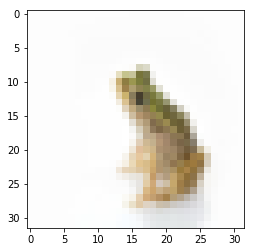

In [33]:
import requests
from PIL import Image
import PIL.ImageOps

externalPhotos = [] 

externalPhotos.append('https://i.imgur.com/L93iqLv.jpg')
externalPhotos.append('https://i.imgur.com/5I6c1Xf.jpg')
externalPhotos.append('https://i.imgur.com/zClfNPb.jpg')

externalPhotos.append('https://www.petlove.com.br/dicas/wp-content/uploads/2018/05/golden-idoso.jpg')
externalPhotos.append('http://data.biovet.com.br/file/2018/10/29/H104520-F00000-V006-2000x0.jpeg')

externalPhotos.append('https://s.hdnux.com/photos/75/50/00/16154647/5/920x920.jpg')
externalPhotos.append('https://d.newsweek.com/en/full/1336950/deer-zombie-deer-chronic-wasting-disease.jpg')
externalPhotos.append('https://d39w7f4ix9f5s9.cloudfront.net/b3/d0/80815f4d46cfbf551f19719fedd9/20160808primeairplaneinflight-20.JPG')


externalPhotos.append('https://www.gazetadopovo.com.br/viver-bem/wp-content/uploads/2017/03/como-dar-banho-em-gato-600x401.jpg')
externalPhotos.append('https://conteudo.imguol.com.br/c/entretenimento/0b/2019/03/08/goose-o-gato-da-capita-marvel-1552070006188_v2_450x600.jpg')
externalPhotos.append('https://www.gazetadopovo.com.br/viver-bem/wp-content/uploads/2018/07/gato-esfinge-foto-unsplash-600x400.jpg')


externalPhotos.append('https://thenypost.files.wordpress.com/2019/08/frogs-in-packaged-salads.jpg?quality=90&strip=all&w=618&h=410&crop=1')
externalPhotos.append('https://ichef.bbci.co.uk/news/976/cpsprodpb/ED57/production/_106895706_14e3bcc8-283e-447e-a7c9-5047dbe732bf.jpg')
externalPhotos.append('https://le-www-live-s.legocdn.com/sc/media/lessons/wedo-2/wedo-projects/images/frogs-metamorphosis-project-image-feb9db40c70bcda57e12f5671d4bc278.jpg')


externalPhotos.append('https://www.petmd.com/sites/default/files/frog-care-101.jpg')




comparisonPhotos = []
iind=0

for i in externalPhotos:  
  print(i)  
  ax = fig.add_subplot(2,10,iind+1,xticks=[],yticks=[])
  iind=iind+1
  response = requests.get(i,stream = True)  
  img = Image.open(response.raw)
  plt.imshow(img)
  print(i,response)  
  #imag = transform(img)
  comparisonPhotos.append(img)  
  imag = transform(img)
  plt.imshow(im_convert(imag))
  
  ax.set_title(idx)

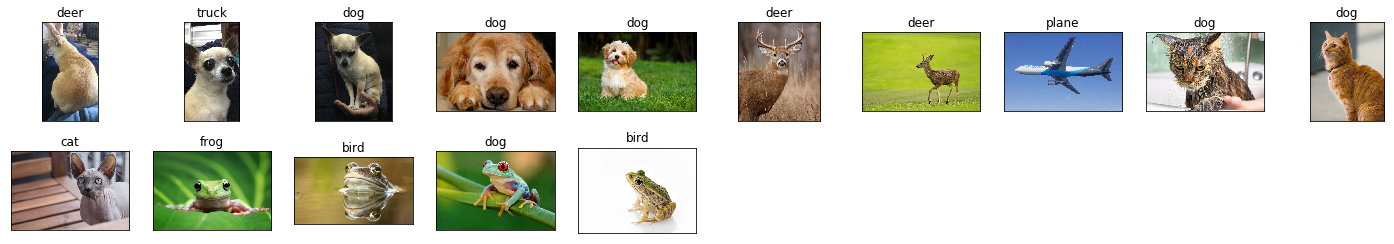

In [34]:
fig = plt.figure(figsize=(25,4))

acertos = 0
erros = 0

for idx in np.arange(len(comparisonPhotos)):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(comparisonPhotos[idx])   
  imag = transform(comparisonPhotos[idx])  
  image = imag.to(device).unsqueeze(0)
  output = model(image)
  _, pred = torch.max(output, 1)
  ax.set_title(classes[pred.item()]) 

In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in dataiter:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 93 %
Accuracy of  bird : 55 %
Accuracy of   cat : 54 %
Accuracy of  deer : 71 %
Accuracy of   dog : 62 %
Accuracy of  frog : 79 %
Accuracy of horse : 75 %
Accuracy of  ship : 86 %
Accuracy of truck : 72 %
